In [2]:
import os
import json
from collections import deque
from typing import Dict, List, Optional, Any, Union

from langchain_openai import ChatOpenAI


# Get human objective
# refine it via human in the loop and via adding context (short/long term memory search) -> the output is a json dict of the design
# build the modules and test benches usiiing short and long term memory

In [4]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["SERPAPI_API_KEY"] = os.getenv("SERPAPI_API_KEY")

In [5]:
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
bigllm = ChatOpenAI(model='gpt-4-0125-preview', temperature=0)

# Context for FFT

In [6]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# FFT docs 
url = """https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm""" #"""https://www.fpga4student.com/2017/04/verilog-code-for-16-bit-risc-processor.html"""
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Add 
#docs.extend([*docs_pydantic, *docs_sq])

# Sort the list based on the URLs in 'metadata' -> 'source'
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# Concatenate the 'page_content' of each sorted dictionary
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

# Requirement extraction chain

In [7]:
from FPGA_AGI.chains import RequirementChain

requirement_chain = RequirementChain.from_llm(bigllm)

requirements = requirement_chain.invoke(
    {"objective": "design a 32 bit 16-point FFT to run on an ultra-96 v2 FPGA board. the language must be xilix HLS cpp.", #"design an 8-bit RISC V processor in system verilog", 
     "context" : concatenated_content}
)

In [8]:
import pprint
pprint.pprint(requirements.goals)
requirements.requirements = requirements.requirements[:4]
pprint.pprint(requirements.requirements)

['Design a 32-bit 16-point FFT module to run on an Ultra-96 V2 FPGA board '
 'using the Cooley–Tukey FFT algorithm.',
 'Implement the design in SystemVerilog, focusing on the radix-2 DIT case for '
 'the FFT algorithm.']
['The FFT module must support 32-bit wide complex number inputs and outputs, '
 'accommodating the 16-point FFT size.',
 'Implement the radix-2 DIT (decimation-in-time) version of the Cooley–Tukey '
 'FFT algorithm, as it is the simplest and most common form.',
 'Ensure the design is optimized for the Ultra-96 V2 FPGA board, taking into '
 'account its specific hardware capabilities and limitations.',
 'Include data reordering (bit reversal) as part of the FFT computation '
 'process to ensure the output is in the correct order.']


# Research Agent

In [9]:
# retriever

from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("https://www.jot.fm/issues/issue_2009_07/column2.pdf", extract_images=True) #"https://riscv.org/wp-content/uploads/2017/05/riscv-spec-v2.2.pdf"
pages = loader.load()

In [10]:
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings

embeddings_3_small = OpenAIEmbeddings(model='text-embedding-3-small')
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
texts = text_splitter.split_documents(pages)
pdfsearch = Chroma.from_documents(texts, embeddings_3_small, collection_name= "knowledge_base", persist_directory="./knowledge_base")

In [11]:
from FPGA_AGI.chains import WebsearchCleaner

webcleaner = WebsearchCleaner.from_llm(llm=bigllm)
cleaned_concatenated_content = webcleaner.invoke(concatenated_content)
cleaned_concatenated_content = cleaned_concatenated_content.cleaned
pprint.pprint(cleaned_concatenated_content)

('The Cooley–Tukey algorithm, named after J. W. Cooley and John Tukey, is the '
 'most common fast Fourier transform (FFT) algorithm. It re-expresses the '
 'discrete Fourier transform (DFT) of an arbitrary composite size N = N1N2 in '
 'terms of N1 smaller DFTs of sizes N2, recursively, to reduce the computation '
 'time to O(N log N) for highly composite N (smooth numbers). Because of the '
 "algorithm's importance, specific variants and implementation styles have "
 'become known by their own names, as described below.\n'
 '\n'
 'This algorithm, including its recursive application, was invented around '
 '1805 by Carl Friedrich Gauss, who used it to interpolate the trajectories of '
 'the asteroids Pallas and Juno, but his work was not widely recognized (being '
 'published only posthumously and in Neo-Latin). Gauss did not analyze the '
 'asymptotic computational time, however. Various limited forms were also '
 'rediscovered several times throughout the 19th and early 20th centuri

In [138]:
import importlib
from FPGA_AGI import parameters
importlib.reload(parameters)
from FPGA_AGI import utils
importlib.reload(utils)
from FPGA_AGI import prompts
importlib.reload(prompts)
from FPGA_AGI import chains
importlib.reload(chains)
from langchain_core.prompts import HumanMessagePromptTemplate
from FPGA_AGI import agents
importlib.reload(agents)
from FPGA_AGI.agents import Researcher

bigllm = ChatOpenAI(model='gpt-4-turbo', temperature=0)
R = Researcher(model=bigllm, retriever=pdfsearch.as_retriever(search_kwargs={"k": 1}))

#planner_agent_prompt_human = HumanMessagePromptTemplate.from_template("""You are planning the procedure for the following. Your goal is to collect all the data and perform all the computation necessary for another hardware engineer to build the design seamlessly.
#                    goals:
#                    {goals}
#                    requirements:
#                    {requirements}
#                    user input context:
#                    {input_context}""")
#human_message = planner_agent_prompt_human.format_messages(goals=requirements.goals, requirements=requirements.requirements, input_context= cleaned_concatenated_content)
#result = R.planner_chain.invoke({"messages": human_message})

R.invoke(goals=requirements.goals, requirements=requirements.requirements, input_context= cleaned_concatenated_content)
#result = R.planner_agent.invoke({'goals':requirements.goals, 'requirements':requirements.requirements, 'input_context': concatenated_content})

---QUESTION GENERATION---
[HumanMessage(content='Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    [\'Design a 32-bit 16-point FFT module to run on an Ultra-96 V2 FPGA board using the Cooley–Tukey FFT algorithm.\', \'Implement the design in SystemVerilog, focusing on the radix-2 DIT case for the FFT algorithm.\']\n                    requirements:\n                    [\'The FFT module must support 32-bit wide complex number inputs and outputs, accommodating the 16-point FFT size.\', \'Implement the radix-2 DIT (decimation-in-time) version of the Cooley–Tukey FFT algorithm, as it is the simplest and most common form.\', \'Ensure the design is optimized for the Ultra-96 V2 FPGA board, taking into account its specific hardware capabilities and limitations.\', \'Include data reordering (bit reversal) as part of the FFT computation process to ensure the output is

{'keys': {'decision': 'design'},
 'messages': [HumanMessage(content='Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    [\'Design a 32-bit 16-point FFT module to run on an Ultra-96 V2 FPGA board using the Cooley–Tukey FFT algorithm.\', \'Implement the design in SystemVerilog, focusing on the radix-2 DIT case for the FFT algorithm.\']\n                    requirements:\n                    [\'The FFT module must support 32-bit wide complex number inputs and outputs, accommodating the 16-point FFT size.\', \'Implement the radix-2 DIT (decimation-in-time) version of the Cooley–Tukey FFT algorithm, as it is the simplest and most common form.\', \'Ensure the design is optimized for the Ultra-96 V2 FPGA board, taking into account its specific hardware capabilities and limitations.\', \'Include data reordering (bit reversal) as part of the FFT computation process to 

In [131]:
from pprint import pprint
from copy import deepcopy
#pprint(R.test_var_.overview)
pprint(R.hierarchical_solution_result.graph)
#pprint(R.test_var_.implementation)
bitch = deepcopy(R.hierarchical_solution_result.graph)

[Module(name='FFT_Top_Module', description='Top-level module for the 32-bit 16-point FFT computation using the radix-2 DIT Cooley–Tukey algorithm. This module orchestrates the overall FFT process, including initial data distribution to even and odd computation modules, combination of their outputs using twiddle factors, and final data reordering for bit reversal. It is optimized for parallel processing and efficient memory use on the Ultra-96 V2 FPGA board.', connections=['Even_Indexed_DFT_Module', 'Odd_Indexed_DFT_Module', 'Twiddle_Factor_Combiner', 'Data_Reordering_Module'], ports=['input [31:0] complex_data[15:0]', 'output [31:0] fft_result[15:0]', 'input clk', 'input reset']),
 Module(name='Even_Indexed_DFT_Module', description='Module responsible for computing the DFT of the even-indexed parts of the input array. It processes inputs like x0, x2, x4, etc., and outputs their DFT results. Optimized for efficient computation using DSP slices available on the FPGA.', connections=['Twid

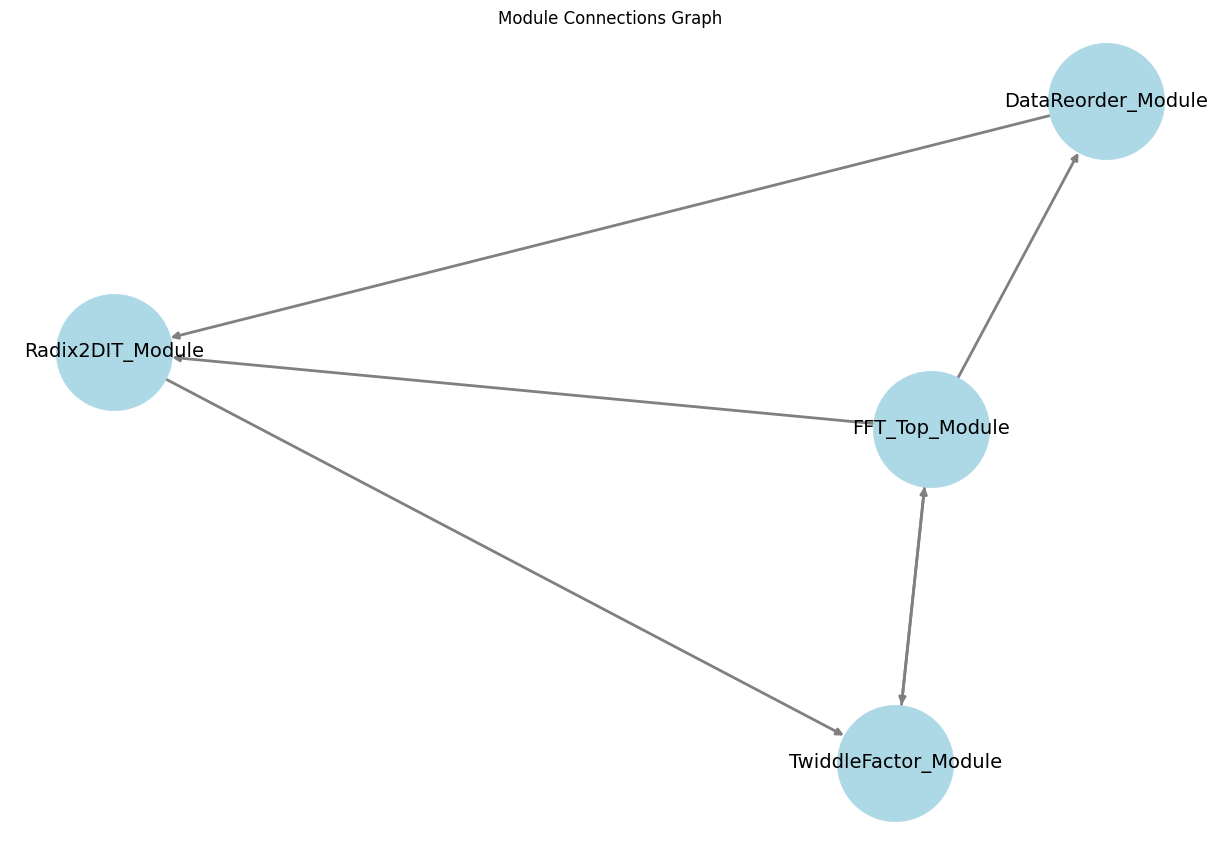

In [139]:
from FPGA_AGI import utils
utils.plot_graph(R.hierarchical_solution_result)

In [17]:
from langchain_core.messages import HumanMessage
state = {'messages': [HumanMessage(content='Calculate the twiddle factors for a 16-point FFT using the radix-2 DIT algorithm. These will be precomputed and stored in a lookup table for the hardware implementation.', name='researcher')]}

R.compute_agent.invoke(state)



> Entering new AgentExecutor chain...

Invoking: `python_run` with `{'code': "import numpy as np\n\nN = 16\n# Calculate twiddle factors for a 16-point FFT\nW = np.array([np.exp(-2j * np.pi * k / N) for k in range(N)])\n\n# Print the twiddle factors\nfor i, w in enumerate(W):\n    print(f'W[{i}] = {w}')"}`


W[0] = (1+0j)
W[1] = (0.9238795325112867-0.3826834323650898j)
W[2] = (0.7071067811865476-0.7071067811865476j)
W[3] = (0.38268343236508984-0.9238795325112867j)
W[4] = (6.123233995736766e-17-1j)
W[5] = (-0.3826834323650897-0.9238795325112867j)
W[6] = (-0.7071067811865475-0.7071067811865476j)
W[7] = (-0.9238795325112867-0.3826834323650899j)
W[8] = (-1-1.2246467991473532e-16j)
W[9] = (-0.9238795325112868+0.38268343236508967j)
W[10] = (-0.7071067811865477+0.7071067811865475j)
W[11] = (-0.38268343236509034+0.9238795325112865j)
W[12] = (-1.8369701987210297e-16+1j)
W[13] = (0.38268343236509+0.9238795325112866j)
W[14] = (0.7071067811865474+0.7071067811865477j)
W[15] = (0.9238795325112865+0

{'messages': [HumanMessage(content='Calculate the twiddle factors for a 16-point FFT using the radix-2 DIT algorithm. These will be precomputed and stored in a lookup table for the hardware implementation.', name='researcher')],
 'output': 'The twiddle factors for a 16-point FFT using the radix-2 DIT algorithm are as follows:\n\n- W[0] = (1+0j)\n- W[1] = (0.9238795325112867-0.3826834323650898j)\n- W[2] = (0.7071067811865476-0.7071067811865476j)\n- W[3] = (0.38268343236508984-0.9238795325112867j)\n- W[4] = (6.123233995736766e-17-1j)\n- W[5] = (-0.3826834323650897-0.9238795325112867j)\n- W[6] = (-0.7071067811865475-0.7071067811865476j)\n- W[7] = (-0.9238795325112867-0.3826834323650899j)\n- W[8] = (-1-1.2246467991473532e-16j)\n- W[9] = (-0.9238795325112868+0.38268343236508967j)\n- W[10] = (-0.7071067811865477+0.7071067811865475j)\n- W[11] = (-0.38268343236509034+0.9238795325112865j)\n- W[12] = (-1.8369701987210297e-16+1j)\n- W[13] = (0.38268343236509+0.9238795325112866j)\n- W[14] = (0.707

In [13]:
from FPGA_AGI.tools import search_web, python_run, Thought
python_run

StructuredTool(name='python_run', description="python_run(code: typing.Annotated[str, 'The python code to execute to generate your results.']) -> str - Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`.", args_schema=<class 'pydantic.main.python_runSchema'>, func=<function python_run at 0x0000024BDBE3AD40>)

In [13]:
search_web

StructuredTool(name='search_web', description='search_web(keywords: str) - A web search tool.', args_schema=<class 'pydantic.main.search_webSchema'>, func=<function search_web at 0x00000247DD34C0D0>)

In [ ]:
response = R.research_agent.invoke({"messages": human_message})

In [ ]:
response[0].decision

'compute'

In [ ]:
test = []
for i in range(20):
    response = R.research_agent.invoke({"messages": human_message})
    test.append(response)

In [ ]:
test

[[decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='sol

# Compute Agent

In [ ]:
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, FunctionMessage
from langchain.prompts import PromptTemplate, MessagesPlaceholder, ChatPromptTemplate
from FPGA_AGI.tools import python_run
from langchain.agents import AgentExecutor, create_openai_tools_agent
messages = [HumanMessage(content = "compute the twiddle factors of 64 point FFT", name="Researcher")]
#response = R.compute_agent.invoke({"messages": messages})

#compute_llm_with_tool = bigllm.bind(
#    tools=[python_run],
#    tool_choice={"type": "function", "function": {"name": "python_run"}},
#)

## Prompt
#compute_prompt = ChatPromptTemplate.from_messages(
#    [(
#            "system","""
#            You are a hardware engineer helping a senior hardware engineer with their computational needs. In order to do that you use python."""
#        ),
#        MessagesPlaceholder(variable_name="messages"),
#    ]
#)
## Chain
#compute_agent = compute_prompt | compute_llm_with_tool | JsonOutputFunctionsParser()


system_prompt = """You are a hardware engineer helping a senior hardware engineer with their computational needs. In order to do that you use python.
Work autonomously according to your specialty, using the tools available to you.
You must write a code to compute what is asked of you in python to answer the question.
Do not answer based on your own knowledge/memory. instead write a python code that computes the answer, run it, and observe the results.
You must print the results in your response no matter how long or large they might be. 
You must completely print the results. Do not leave any place holders. Do not use ... 
Do not ask for clarification. You also do not refuse to answer the question.
Your other team members (and other teams) will collaborate with you with their own specialties."""
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            system_prompt,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)
agent = create_openai_tools_agent(bigllm, [python_run], prompt)
executor = AgentExecutor(agent=agent, tools=[python_run])

In [ ]:
#compute_agent.invoke({"messages": messages})
#python_run
response = executor.invoke({"messages": messages})

In [ ]:
response['output']

'W0: (1+0j)\nW1: (0.9987954562051724-0.049067674327418015j)\nW2: (0.9951847266721969-0.0980171403295606j)\nW3: (0.989176509964781-0.14673047445536175j)\nW4: (0.9807852804032304-0.19509032201612825j)\nW5: (0.970031253194544-0.24298017990326387j)\nW6: (0.9569403357322088-0.29028467725446233j)\nW7: (0.9415440651830208-0.33688985339222005j)\nW8: (0.9238795325112867-0.3826834323650898j)\nW9: (0.9039892931234433-0.4275550934302821j)\nW10: (0.881921264348355-0.47139673682599764j)\nW11: (0.8577286100002721-0.5141027441932217j)\nW12: (0.8314696123025452-0.5555702330196022j)\nW13: (0.8032075314806449-0.5956993044924334j)\nW14: (0.773010453362737-0.6343932841636455j)\nW15: (0.7409511253549591-0.6715589548470183j)\nW16: (0.7071067811865476-0.7071067811865475j)\nW17: (0.6715589548470183-0.7409511253549591j)\nW18: (0.6343932841636455-0.773010453362737j)\nW19: (0.5956993044924334-0.8032075314806449j)\nW20: (0.5555702330196022-0.8314696123025452j)\nW21: (0.5141027441932217-0.8577286100002721j)\nW22: (

# Modular design agent

In [68]:
from FPGA_AGI.tools import search_web, python_run, Thought
from FPGA_AGI import prompts
import importlib
importlib.reload(prompts)
from FPGA_AGI.prompts import hierarchical_agent_prompt_human, module_agent_prompt_human
from FPGA_AGI import agents
import importlib
importlib.reload(agents)
from FPGA_AGI.agents import HierarchicalDesignAgent

#gpt-4-0125-preview gpt-4-1106-preview
model = ChatOpenAI(model='gpt-4-0125-preview', temperature=0, streaming=True)

tools = [search_web]
messages = hierarchical_agent_prompt_human.format_messages(goals=requirements.goals, requirements='\n'.join(requirements.requirements)) #.to_messages()

multiple_attempts = []


agent = HierarchicalDesignAgent(model, tools)
hierarchical_response = agent.invoke({'messages': messages})


Thought
search_web
Thought
search_web
Thought


KeyboardInterrupt: 

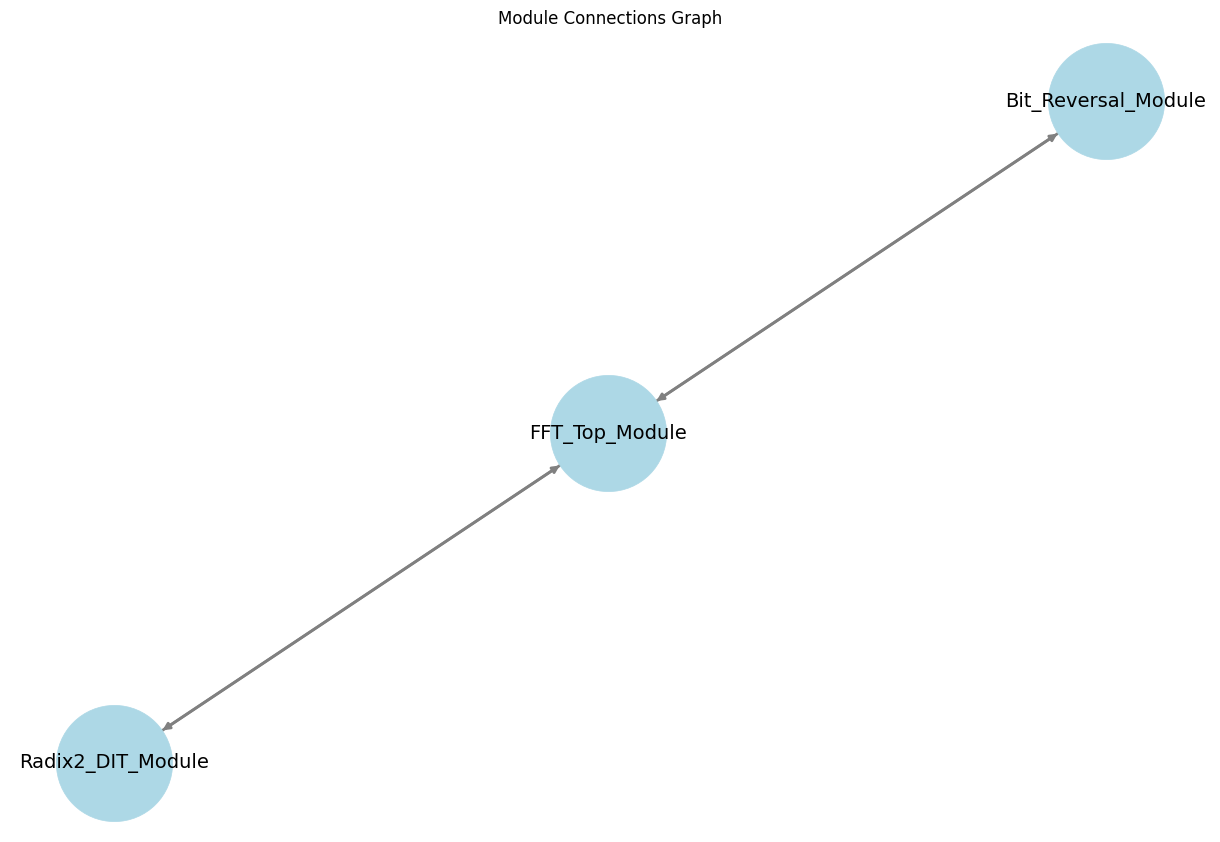

In [18]:
from FPGA_AGI.utils import plot_graph

plot_graph(hierarchicalmodules = multiple_attempts[4], save_path = None)

In [59]:
str(hierarchical_response)

"graph=[Module(name='FFT_TopModule', description='Top module for the 32-bit 16-point FFT design incorporating the radix-2 DIT variant of the Cooley–Tukey FFT algorithm. This module serves as the entry point for the FFT operation, managing data flow and module coordination.', connections=['FFT_DataInput', 'FFT_Core', 'FFT_DataOutput'], ports=['clk (input)', 'rst_n (input)', 'data_in (input, 32-bit complex)', 'data_out (output, 32-bit complex)', 'start (input)', 'done (output)'], notes='Ensure this module is optimized for speed and resource utilization on the Ultra-96 V2 FPGA board. Utilize efficient pipelining and parallel processing techniques where applicable.'), Module(name='FFT_DataInput', description='Module responsible for data input handling. It formats and buffers incoming data to be processed by the FFT_Core module.', connections=['FFT_Core'], ports=['clk (input)', 'rst_n (input)', 'data_in (input, 32-bit complex)', 'data_ready (output)'], notes='This module should ensure data 

# More agents

In [ ]:
goals = 'Design an 8-bit RISC V processor using SystemVerilog.' 

requirements = '\n'.join(['1. The processor must be designed based on the RISC V instruction set and '
'should follow a Harvard-type data path structure.',
'2. Implement memory access instructions including Load Word (LD) and Store '
'Word (ST) with the specified operations.',
'3. Implement data processing instructions including Add (ADD), Subtract '
'(SUB), Invert (INV), Logical Shift Left (LSL), Logical Shift Right (LSR), '
'Bitwise AND (AND), Bitwise OR (OR), and Set on Less Than (SLT) with the '
'specified operations.',
'4. Implement control flow instructions including Branch on Equal (BEQ), '
'Branch on Not Equal (BNE), and Jump (JMP) with the specified operations.',
'5. Design the processor control unit to generate appropriate control signals '
'for each instruction type.',
'6. Design the ALU control unit to generate the correct ALU operation based '
'on the ALUOp signal and the opcode.',
'7. Implement instruction memory, data memory, register file, ALU, ALU '
'control unit, datapath unit, and control unit modules in SystemVerilog.',
'8. Ensure the processor supports a 16-bit instruction format and operates on '
'8-bit data widths.',
'9. The processor must be capable of executing the provided instruction set '
'with correct control and data flow for each instruction type.',
'10. Verify the processor design using a testbench that simulates various '
'instruction executions and validates the functionality of the processor.'])

In [146]:
from FPGA_AGI import prompts
import importlib
importlib.reload(prompts)
from FPGA_AGI import tools
import importlib
importlib.reload(tools)
from FPGA_AGI.prompts import hierarchical_agent_prompt_human, module_design_agent_prompt
from FPGA_AGI import agents
import importlib
importlib.reload(agents)
from FPGA_AGI.agents import GenericToolCallingAgent, CodeModuleResponse

h = module_agent_prompt_human.format_messages(hierarchical_design='16 bit fft twiddle factor module', modules_built='', current_module='16 bit fft twiddle factor module (after you compute them via python tool)')
agent = GenericToolCallingAgent(bigllm, prompt=module_design_agent_prompt,
            tools=[search_web, python_run], response_format=CodeModuleResponse
            )

In [147]:
response = agent.stream({"messages": h})

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"thought":"First, I need to understand the requirements for the 16 bit FFT twiddle factor module. This involves calculating the twiddle factors for a 16-bit FFT. Twiddle factors are complex exponential values used in the FFT algorithm to reduce the computational complexity. I should use the Python tool to compute these twiddle factors."}', 'name': 'Thought'}}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 658, 'total_tokens': 735}, 'model_name': 'gpt-4-0125-preview', 'system_fingerprint': 'fp_b77cb481ed', 'finish_reason': 'function_call', 'logprobs': None})]}

---

Thought
Output from node 'action':
---
{'messages': [FunctionMessage(content='Your thought is: First, I need to understand the requirements for the 16 bit FFT twiddle factor module. This involves calculating the twiddle factors for a 16-bit FFT. Twiddle factors are complex expon

In [143]:
response['__end__']

{'messages': [HumanMessage(content='Write the HLS/HDL code in verilog for the following desgin. Note that the design consists of modules with    input/output and connecting modules already designed for you. Your task is to build the modules consistently with the modules that you have already build and with the overal desing.    note also that the note section of each module provides you with necessary information, guidelines and other helpful elements to perform your design.\n    \n    Hierarchical design:\n    16 bit fft twiddle factor module\n                                                                 \n    Modules built so far:\n    \n    \n    Current Module:\n    16 bit fft twiddle factor module (after you compute them via python tool)\n    '),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"thought":"First, I need to understand the requirements for the 16 bit FFT twiddle factor module. This involves calculating the twiddle factors for a 16-bit FF

# counting how many times the agent fails out of 10 repeats
failure = 0
outputs = []
for i in range(10):
    try:
        output = app.invoke(inputs)
        out = json.loads(output['messages'][-1].additional_kwargs["function_call"]["arguments"])
        outputs.append(out)
    except:
        failure += 1

print(f'Failed {failure} times out of 10 runs.')
out['graph']

from openai import OpenAI
client = OpenAI()
import json
from tqdm import tqdm

l = {}
for T in tqdm(range(0, 11)):
    response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",
    messages=[
        {
        "role": "system",
        "content": "You will be provided with a high level idea of a hardware. come up with a list of modules that such a hardware needs. only come up with a list of names."
        },
        {
        "role": "user",
        "content": "We want to build a competitor to GPU based on conventional logic. We want this new tool to beat GPUs for AI applications."
        }
    ],
    temperature=T*0.2,
    max_tokens=400,
    top_p=1
    )
    l[f'idea_{T}'] = {'T': T*0.2, 'content': response.choices[0].message.content}

out_file = open("test_gpt_3.5.json", "w") 
  
json.dump(l, out_file, indent = 6) 
  
out_file.close() 